# Clustering Crypto

In [114]:
# Initial imports
import requests
import pandas as pd
import hvplot.pandas
from pathlib import Path
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [115]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"
response = requests.get(url).json()

In [116]:
# Create a DataFrame
crypto_df = pd.DataFrame(response['Data']).T
crypto_df.head()
# crypto_df.to_csv("cryptodata.csv")

,Algorithm,AssetLaunchDate,AssetTokenStatus,BlockNumber,BlockReward,BlockTime,BuiltOn,CoinName,ContentCreatedOn,DecimalPoints,...,PlatformType,ProofType,Rating,SmartContractAddress,SortOrder,Sponsored,Symbol,Taxonomy,TotalCoinsMined,Url
42,Scrypt,0000-00-00,N/A,0,0,0,NaN,42 Coin,1427211129,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,34,False,42,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/42/overview
300,N/A,2017-07-01,N/A,0,0,0,ETH,300 token,1517935016,18,...,token,N/A,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",0xaec98a708810414878c3bcdf46aad31ded4a4557,2212,False,300,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",300,/coins/300/overview
365,X11,0000-00-00,N/A,0,0,0,NaN,365Coin,1480032918,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,916,False,365,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/365/overview
404,Scrypt,0000-00-00,N/A,0,0,0,NaN,404Coin,1466100361,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,602,False,404,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/404/overview
433,N/A,NaN,Finished,NaN,NaN,NaN,NaN,433 Token,1541597321,NaN,...,NaN,N/A,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,3505,False,433,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",NaN,/coins/433/overview


### Data Preprocessing

In [117]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
# *******TotalCoinSupply is NOT a valid column - use MaxSupply*******
crypto_df=crypto_df[['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','MaxSupply']]
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,True,PoW/PoS,0,0
300,300 token,N/A,True,N/A,300,300
365,365Coin,X11,True,PoW/PoS,0,0
404,404Coin,Scrypt,True,PoW/PoS,0,0
433,433 Token,N/A,False,N/A,NaN,NaN
611,SixEleven,SHA-256,True,PoW,0,0
808,808,SHA-256,True,PoW/PoS,0,0
888,Octocoin,N/A,True,PoW,0,0
1337,EliteCoin,X13,True,PoW/PoS,0,0
2015,2015 coin,X11,True,PoW/PoS,0,0


In [118]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df["IsTrading"] == True]
print(crypto_df.shape)
crypto_df.head(10)

(4974, 6)


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,True,PoW/PoS,0,0
300,300 token,N/A,True,N/A,300,300
365,365Coin,X11,True,PoW/PoS,0,0
404,404Coin,Scrypt,True,PoW/PoS,0,0
611,SixEleven,SHA-256,True,PoW,0,0
808,808,SHA-256,True,PoW/PoS,0,0
888,Octocoin,N/A,True,PoW,0,0
1337,EliteCoin,X13,True,PoW/PoS,0,0
2015,2015 coin,X11,True,PoW/PoS,0,0
BTCD,BitcoinDark,SHA-256,True,PoW/PoS,NaN,NaN


In [119]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df[crypto_df["Algorithm"] != "N/A"]
print(crypto_df.shape)
crypto_df.head(10)

(1485, 6)


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,True,PoW/PoS,0,0
365,365Coin,X11,True,PoW/PoS,0,0
404,404Coin,Scrypt,True,PoW/PoS,0,0
611,SixEleven,SHA-256,True,PoW,0,0
808,808,SHA-256,True,PoW/PoS,0,0
1337,EliteCoin,X13,True,PoW/PoS,0,0
2015,2015 coin,X11,True,PoW/PoS,0,0
BTCD,BitcoinDark,SHA-256,True,PoW/PoS,NaN,NaN
CRAIG,CraigsCoin,X11,True,PoS,NaN,NaN
XBS,Bitstake,X11,True,PoW/PoS,NaN,NaN


In [120]:
# Remove the "IsTrading" column
crypto_df.drop("IsTrading", axis=1, inplace=True)
print(crypto_df.shape)
crypto_df.head(10)

(1485, 5)


,CoinName,Algorithm,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,PoW/PoS,0,0
365,365Coin,X11,PoW/PoS,0,0
404,404Coin,Scrypt,PoW/PoS,0,0
611,SixEleven,SHA-256,PoW,0,0
808,808,SHA-256,PoW/PoS,0,0
1337,EliteCoin,X13,PoW/PoS,0,0
2015,2015 coin,X11,PoW/PoS,0,0
BTCD,BitcoinDark,SHA-256,PoW/PoS,NaN,NaN
CRAIG,CraigsCoin,X11,PoS,NaN,NaN
XBS,Bitstake,X11,PoW/PoS,NaN,NaN


In [121]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna(axis=0, how="any")
print(crypto_df.shape)
crypto_df.head(10)

(278, 5)


,CoinName,Algorithm,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,PoW/PoS,0,0
365,365Coin,X11,PoW/PoS,0,0
404,404Coin,Scrypt,PoW/PoS,0,0
611,SixEleven,SHA-256,PoW,0,0
808,808,SHA-256,PoW/PoS,0,0
1337,EliteCoin,X13,PoW/PoS,0,0
2015,2015 coin,X11,PoW/PoS,0,0
ACOIN,ACoin,SHA-256,PoW,0,0
XMY,MyriadCoin,Multiple,PoW,0,2000000000
SXC,SexCoin,Scrypt,PoW,0,0


In [122]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df["TotalCoinsMined"] > 0]
print(crypto_df.shape)
crypto_df.head(10)

(135, 5)


,CoinName,Algorithm,ProofType,TotalCoinsMined,MaxSupply
NVC,NovaCoin,Scrypt,PoW/PoS,3.18151e+06,-1
XCP,CounterParty,SHA-256,PoW,2.61512e+06,-1
NSR,NuShares,PoS,PoS,5.85505e+09,0
MONA,MonaCoin,Scrypt,PoW,8.1021e+07,-1
TRI,Triangles Coin,X13,PoW/PoS,175041,0
EMC,Emercoin,SHA-256,PoW/PoS,4.71287e+07,-1
SAFEX,SafeExchangeCoin,Scrypt,PoC,2147483647,-1
CMTC,CometCoin,Scrypt,PoW,872830,0
XSN,Stakenet,X11,TPoS,1.18456e+08,-1
CHAT,OpenChat,Scrypt,PoW/PoS,1000000000,-1


In [123]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df.iloc[:] != 'N/A'].dropna()
crypto_df.head(10)

,CoinName,Algorithm,ProofType,TotalCoinsMined,MaxSupply
NVC,NovaCoin,Scrypt,PoW/PoS,3.18151e+06,-1
XCP,CounterParty,SHA-256,PoW,2.61512e+06,-1
NSR,NuShares,PoS,PoS,5.85505e+09,0
MONA,MonaCoin,Scrypt,PoW,8.1021e+07,-1
TRI,Triangles Coin,X13,PoW/PoS,175041,0
EMC,Emercoin,SHA-256,PoW/PoS,4.71287e+07,-1
SAFEX,SafeExchangeCoin,Scrypt,PoC,2147483647,-1
CMTC,CometCoin,Scrypt,PoW,872830,0
XSN,Stakenet,X11,TPoS,1.18456e+08,-1
CHAT,OpenChat,Scrypt,PoW/PoS,1000000000,-1


In [124]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coins_name = pd.DataFrame(crypto_df["CoinName"], index=crypto_df.index)
print(coins_name.shape)
coins_name.head()

(117, 1)


,CoinName
NVC,NovaCoin
XCP,CounterParty
NSR,NuShares
MONA,MonaCoin
TRI,Triangles Coin


In [125]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop("CoinName", axis=1)
print(crypto_df.shape)
crypto_df.head(10)

(117, 4)


,Algorithm,ProofType,TotalCoinsMined,MaxSupply
NVC,Scrypt,PoW/PoS,3.18151e+06,-1
XCP,SHA-256,PoW,2.61512e+06,-1
NSR,PoS,PoS,5.85505e+09,0
MONA,Scrypt,PoW,8.1021e+07,-1
TRI,X13,PoW/PoS,175041,0
EMC,SHA-256,PoW/PoS,4.71287e+07,-1
SAFEX,Scrypt,PoC,2147483647,-1
CMTC,Scrypt,PoW,872830,0
XSN,X11,TPoS,1.18456e+08,-1
CHAT,Scrypt,PoW/PoS,1000000000,-1


In [126]:
# Create dummy variables for text features
X = pd.get_dummies(data=crypto_df, columns=["Algorithm", "ProofType"])
print(X.shape)
X.head(10)

(117, 72)


,TotalCoinsMined,MaxSupply,Algorithm_BEP-2,Algorithm_BLAKE256,Algorithm_BMW512 / Echo512,Algorithm_Blake2B + SHA3,Algorithm_Blake2b,Algorithm_C31,Algorithm_CryptoNight,Algorithm_CryptoNight-Heavy,...,ProofType_PoW,ProofType_PoW/PoS,ProofType_PoW/PoSe,ProofType_PoW/nPoS,ProofType_Proof of Authority,ProofType_SPoS,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW,ProofType_mPoW
NVC,3.18151e+06,-1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
XCP,2.61512e+06,-1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
NSR,5.85505e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MONA,8.1021e+07,-1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TRI,175041,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
EMC,4.71287e+07,-1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
SAFEX,2147483647,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CMTC,872830,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
XSN,1.18456e+08,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CHAT,1000000000,-1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [127]:
# Standardize data
X = StandardScaler().fit_transform(X)
X[:5]

array([[-0.17658936, -0.1370063 , -0.09284767, -0.13187609, -0.09284767,
        -0.09284767, -0.13187609, -0.13187609, -0.13187609, -0.09284767,
        -0.09284767, -0.23249528, -0.13187609, -0.09284767, -0.09284767,
        -0.09284767, -0.30570892, -0.09284767, -0.21128856, -0.09284767,
        -0.09284767, -0.13187609, -0.09284767, -0.09284767, -0.09284767,
        -0.09284767, -0.09284767, -0.16222142, -0.09284767, -0.09284767,
        -0.13187609, -0.16222142, -0.09284767, -0.16222142, -0.13187609,
        -0.3380617 , -0.13187609, -0.09284767, -0.09284767, -0.09284767,
         2.34520788, -0.09284767, -0.09284767, -0.09284767, -0.09284767,
        -0.09284767, -0.18814417, -0.09284767, -0.21128856, -0.09284767,
        -0.09284767, -0.09284767, -0.09284767, -0.25226249, -0.09284767,
        -0.09284767, -0.13187609, -0.13187609, -0.09284767, -0.28867513,
        -0.09284767, -0.09284767, -1.00858385,  2.02162225, -0.09284767,
        -0.09284767, -0.09284767, -0.09284767, -0.0

### Reducing Dimensions Using PCA

In [128]:
# Use PCA to reduce dimension to 3 principal components
n_comp = 3
pca = PCA(n_components=n_comp)
principal_components = pca.fit_transform(X)
principal_components

array([[-1.29118965e+00, -6.40852673e-01, -5.81725720e-01],
       [ 1.67414840e+00, -2.18179786e-01,  1.17479401e-03],
       [-1.28567000e+00,  6.80851495e-02, -4.98684231e-01],
       [ 7.10953462e-01, -6.98112082e-01, -2.47387391e-01],
       [-2.03321349e+00, -5.29276103e-01, -7.14362580e-01],
       [-3.27802323e-01, -1.60463211e-01, -3.33180297e-01],
       [-9.23281364e-01, -5.17126604e-01, -3.31401677e-01],
       [ 7.10827433e-01, -6.98411552e-01, -2.47376411e-01],
       [-1.18408529e+00, -4.65170177e-01, -1.81934978e-01],
       [-1.28962221e+00, -6.37128109e-01, -5.81862286e-01],
       [ 1.42900725e+00, -6.96249226e-01, -3.02248993e-02],
       [-1.54724298e+00,  8.78665319e-01,  6.16247835e+00],
       [ 1.22841568e+00, -6.10079030e-01, -4.60690702e-02],
       [ 4.66883461e-01, -6.27858475e-01, -1.38784578e-01],
       [ 1.67422835e+00, -2.18046719e-01,  1.18945284e-03],
       [ 1.16323174e+00, -7.08103223e-01, -6.19914860e-02],
       [ 1.48016770e+00, -6.75760595e-01

In [129]:
# Create a DataFrame with the principal components data
col_names = [f"PC {i}" for i in range(1, n_comp + 1)]
pcs_df = pd.DataFrame(principal_components, columns=col_names, index=crypto_df.index)
print(pcs_df.shape)
pcs_df.head(10)

(117, 3)


,PC 1,PC 2,PC 3
NVC,-1.291190,-0.640853,-0.581726
XCP,1.674148,-0.218180,0.001175
NSR,-1.285670,0.068085,-0.498684
MONA,0.710953,-0.698112,-0.247387
TRI,-2.033213,-0.529276,-0.714363
EMC,-0.327802,-0.160463,-0.333180
SAFEX,-0.923281,-0.517127,-0.331402
CMTC,0.710827,-0.698412,-0.247376
XSN,-1.184085,-0.465170,-0.181935
CHAT,-1.289622,-0.637128,-0.581862


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [130]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
l_curv = {"k": k, "inertia": inertia}
df_curv = pd.DataFrame(l_curv)
df_curv.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=4`

In [131]:
# Initialize the K-Means model
kmodel = KMeans(n_clusters=4, random_state=0)

# Fit the model
kmodel.fit(pcs_df)

# Predict clusters
predictions = kmodel.predict(pcs_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.concat([crypto_df, pcs_df], axis=1, sort=False)
clustered_df["CoinName"] = coins_name["CoinName"]
clustered_df["Class"] = kmodel.labels_
print(clustered_df.shape)
clustered_df.head(10)

(117, 9)


,Algorithm,ProofType,TotalCoinsMined,MaxSupply,PC 1,PC 2,PC 3,CoinName,Class
NVC,Scrypt,PoW/PoS,3.18151e+06,-1,-1.291190,-0.640853,-0.581726,NovaCoin,0
XCP,SHA-256,PoW,2.61512e+06,-1,1.674148,-0.218180,0.001175,CounterParty,2
NSR,PoS,PoS,5.85505e+09,0,-1.285670,0.068085,-0.498684,NuShares,0
MONA,Scrypt,PoW,8.1021e+07,-1,0.710953,-0.698112,-0.247387,MonaCoin,2
TRI,X13,PoW/PoS,175041,0,-2.033213,-0.529276,-0.714363,Triangles Coin,0
EMC,SHA-256,PoW/PoS,4.71287e+07,-1,-0.327802,-0.160463,-0.333180,Emercoin,0
SAFEX,Scrypt,PoC,2147483647,-1,-0.923281,-0.517127,-0.331402,SafeExchangeCoin,0
CMTC,Scrypt,PoW,872830,0,0.710827,-0.698412,-0.247376,CometCoin,2
XSN,X11,TPoS,1.18456e+08,-1,-1.184085,-0.465170,-0.181935,Stakenet,0
CHAT,Scrypt,PoW/PoS,1000000000,-1,-1.289622,-0.637128,-0.581862,OpenChat,0


### Visualizing Results

#### 3D-Scatter with Clusters

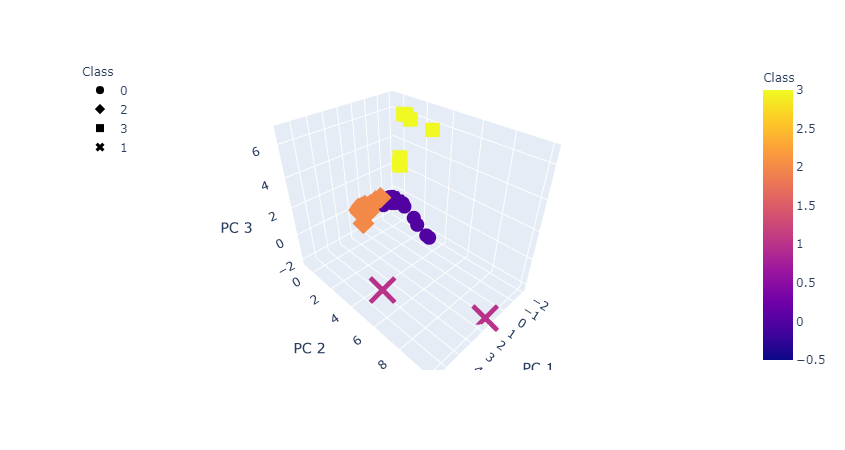

In [132]:
# Create a 3D-Scatter with the PCA data and the clusters
fig3d = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    hover_name="CoinName",
    hover_data=["Algorithm"],
    width=800,
)
fig3d.update_layout(legend=dict(x=0, y=1))
fig3d.show()

#### Table of Tradable Cryptocurrencies

In [133]:
# Table with tradable cryptos
clustered_df[
    [
        "CoinName",
        "Algorithm",
        "ProofType",
        "MaxSupply",
        "TotalCoinsMined",
        "Class",
    ]
].hvplot.table()

:Table   [CoinName,Algorithm,ProofType,MaxSupply,TotalCoinsMined,Class]

In [134]:
# Print the total number of tradable cryptocurrencies
print(f"There are {clustered_df.shape[0]} tradable cryptocurrencies.")

There are 117 tradable cryptocurrencies.


#### Scatter Plot with Tradable Cryptocurrencies

In [135]:
# Scale data to create the scatter plot
mm_scaler = MinMaxScaler()
splot_data = mm_scaler.fit_transform(
    clustered_df[["MaxSupply", "TotalCoinsMined"]]
)
splot_df = pd.DataFrame(
    splot_data, columns=["MaxSupply", "TotalCoinsMined"], index=clustered_df.index
)
splot_df["CoinName"] = clustered_df["CoinName"]
splot_df["Class"] = clustered_df["Class"]
splot_df.head()

,MaxSupply,TotalCoinsMined,CoinName,Class
NVC,0.000000e+00,0.000003,NovaCoin,0
XCP,0.000000e+00,0.000002,CounterParty,2
NSR,9.999833e-13,0.005855,NuShares,0
MONA,0.000000e+00,0.000081,MonaCoin,2
TRI,9.999833e-13,0.000000,Triangles Coin,0


In [136]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
splot_df.hvplot.scatter(
    x="TotalCoinsMined", y="MaxSupply", hover_cols=["CoinName"], by="Class"
)

:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (MaxSupply,CoinName)